In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from scipy.stats.mstats import winsorize
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
# load the dataset
df_loandata = pd.read_csv("LoanData.csv")

In [3]:
df_loandata.shape

(227741, 112)

In [4]:
# return first 5 rows to get a feel for the data
df_loandata.head()

,ReportAsOfEOD,LoanId,LoanNumber,ListedOnUTC,BiddingStartedOn,BidsPortfolioManager,BidsApi,BidsManual,PartyId,NewCreditCustomer,...,PreviousEarlyRepaymentsCountBeforeLoan,GracePeriodStart,GracePeriodEnd,NextPaymentDate,NextPaymentNr,NrOfScheduledPayments,ReScheduledOn,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost,ActiveLateLastPaymentCategory
0,2022-04-08,66AE108B-532B-4BB3-BAB7-0019A46412C1,483449,2016-03-23 16:07:19,2016-03-23 16:07:19,970,1150.0,5.0,{EBF05573-554D-4A3B-BC77-A2CF00B7D110},False,...,0.0,2019-10-28,2020-01-27,NaN,NaN,NaN,NaN,0.00,62.31,1-7
1,2022-04-08,D152382E-A50D-46ED-8FF2-0053E0C86A70,378148,2015-06-25 11:02:28,2015-06-25 11:02:28,1295,0.0,1705.0,{46C6CBA4-0FBE-44AD-9304-A3EF0111A5FB},False,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,47.08,180+
2,2022-04-08,87342E13-66CB-483F-833A-007953E50C78,451831,2016-01-14 10:00:21,2016-01-14 10:00:21,2700,565.0,5835.0,{CA64DA9B-8E95-450E-9EFE-A58601016DB2},True,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,259.67,1659.60,180+
3,2022-04-08,87227056-6BF9-410C-98D1-008F788E122A,349381,2015-03-24 15:55:44,2015-03-24 15:55:44,1115,0.0,385.0,{F08F654D-DB2E-4C4B-8C90-A46100FCE7B6},True,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,215.05,180+
4,2022-04-08,2DDE6336-E466-4624-A337-00A0ED1A1468,443082,2015-12-17 10:12:00,2015-12-17 10:12:00,305,0.0,785.0,{DAFC5C08-8201-4654-9D06-A56D00084659},True,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,180+


In [5]:
df_loandata.dtypes

ReportAsOfEOD                           object
LoanId                                  object
LoanNumber                               int64
ListedOnUTC                             object
BiddingStartedOn                        object
                                        ...   
NrOfScheduledPayments                  float64
ReScheduledOn                           object
PrincipalDebtServicingCost             float64
InterestAndPenaltyDebtServicingCost    float64
ActiveLateLastPaymentCategory           object
Length: 112, dtype: object

In [6]:
# check missing values per variable
df_loandata.isnull().sum()

ReportAsOfEOD                               0
LoanId                                      0
LoanNumber                                  0
ListedOnUTC                                 0
BiddingStartedOn                            0
                                        ...  
NrOfScheduledPayments                   89736
ReScheduledOn                          152485
PrincipalDebtServicingCost             142668
InterestAndPenaltyDebtServicingCost    142668
ActiveLateLastPaymentCategory          135606
Length: 112, dtype: int64

In [7]:
# percentage of missing values per variable
df_loandata.isna().mean().round(4) * 100

ReportAsOfEOD                           0.00
LoanId                                  0.00
LoanNumber                              0.00
ListedOnUTC                             0.00
BiddingStartedOn                        0.00
                                       ...  
NrOfScheduledPayments                  39.40
ReScheduledOn                          66.96
PrincipalDebtServicingCost             62.64
InterestAndPenaltyDebtServicingCost    62.64
ActiveLateLastPaymentCategory          59.54
Length: 112, dtype: float64

In [8]:
# loan status values
df_loandata.Status.unique()

array(['Late', 'Repaid', 'Current'], dtype=object)

In [9]:
# average loan amount
df_loandata.Amount.mean()

2567.5800626672403

In [10]:
df_loandata.describe()

,LoanNumber,BidsPortfolioManager,BidsApi,BidsManual,ApplicationSignedHour,ApplicationSignedWeekday,VerificationType,LanguageCode,Age,DateOfBirth,...,InterestAndPenaltyBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBefoleLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentNr,NrOfScheduledPayments,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost
count,2.277410e+05,227741.000000,227741.000000,227741.000000,227741.000000,227741.000000,227691.000000,227741.000000,227741.000000,0.0,...,174005.000000,227733.000000,227733.000000,143412.000000,59560.000000,227733.000000,138005.000000,138005.000000,85073.000000,85073.000000
mean,1.505963e+06,654.978620,21.940934,411.251584,13.300236,3.939840,3.224251,2.733263,40.279550,NaN,...,939.411628,1.574054,3218.448641,1033.327888,400.018159,0.055060,5.682055,58.742604,11.276449,202.890956
std,7.805647e+05,1135.072911,131.386333,659.429789,4.985193,1.770563,1.275436,1.784499,12.405472,NaN,...,2966.275227,2.512630,5018.762465,1940.630770,1739.678798,0.324178,8.325715,19.550836,81.988941,411.296043
min,3.700000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,...,-2.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,8.251340e+05,68.000000,0.000000,36.000000,10.000000,2.000000,3.000000,1.000000,30.000000,NaN,...,0.000000,0.000000,0.000000,53.687500,0.000000,0.000000,0.000000,59.000000,0.000000,0.000000
50%,1.548821e+06,230.000000,0.000000,164.000000,13.000000,4.000000,4.000000,3.000000,39.000000,NaN,...,0.000000,1.000000,531.000000,332.590000,0.000000,0.000000,3.000000,60.000000,0.000000,18.520000
75%,2.257300e+06,666.000000,3.000000,484.000000,17.000000,5.000000,4.000000,4.000000,49.000000,NaN,...,524.180000,2.000000,4357.000000,1038.722500,0.000000,0.000000,7.000000,60.000000,0.000000,208.440000
max,2.698188e+06,10625.000000,7570.000000,10630.000000,23.000000,7.000000,4.000000,22.000000,77.000000,NaN,...,78982.070000,27.000000,90852.000000,34077.420000,48100.000000,13.000000,60.000000,121.000000,3325.330000,7029.970000


### Define the target

In [11]:
df_loandata["default"] = 1

In [12]:
# If default date is NaN value assign 0. DefaultDate sis used to define the target because we know the borrower has already defaulted
df_loandata.loc[df_loandata["DefaultDate"].isnull(), "default"] = 0
df_loandata

,ReportAsOfEOD,LoanId,LoanNumber,ListedOnUTC,BiddingStartedOn,BidsPortfolioManager,BidsApi,BidsManual,PartyId,NewCreditCustomer,...,GracePeriodStart,GracePeriodEnd,NextPaymentDate,NextPaymentNr,NrOfScheduledPayments,ReScheduledOn,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost,ActiveLateLastPaymentCategory,default
0,2022-04-08,66AE108B-532B-4BB3-BAB7-0019A46412C1,483449,2016-03-23 16:07:19,2016-03-23 16:07:19,970,1150.0,5.0,{EBF05573-554D-4A3B-BC77-A2CF00B7D110},False,...,2019-10-28,2020-01-27,NaN,NaN,NaN,NaN,0.00,62.31,1-7,1
1,2022-04-08,D152382E-A50D-46ED-8FF2-0053E0C86A70,378148,2015-06-25 11:02:28,2015-06-25 11:02:28,1295,0.0,1705.0,{46C6CBA4-0FBE-44AD-9304-A3EF0111A5FB},False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,47.08,180+,1
2,2022-04-08,87342E13-66CB-483F-833A-007953E50C78,451831,2016-01-14 10:00:21,2016-01-14 10:00:21,2700,565.0,5835.0,{CA64DA9B-8E95-450E-9EFE-A58601016DB2},True,...,NaN,NaN,NaN,NaN,NaN,NaN,259.67,1659.60,180+,1
3,2022-04-08,87227056-6BF9-410C-98D1-008F788E122A,349381,2015-03-24 15:55:44,2015-03-24 15:55:44,1115,0.0,385.0,{F08F654D-DB2E-4C4B-8C90-A46100FCE7B6},True,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,215.05,180+,1
4,2022-04-08,2DDE6336-E466-4624-A337-00A0ED1A1468,443082,2015-12-17 10:12:00,2015-12-17 10:12:00,305,0.0,785.0,{DAFC5C08-8201-4654-9D06-A56D00084659},True,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,180+,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227736,2022-04-08,09999223-3D69-42E3-BAAA-FF7F312AB236,468598,2016-02-17 10:17:35,2016-02-17 10:17:35,6215,70.0,1155.0,{F6CBE499-95EA-467A-B930-A3CD00B3A1CA},False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0
227737,2022-04-08,82CBC729-BEF3-4F4B-97DE-FF8087D4F110,2696211,2022-04-07 07:07:52,2022-04-07 10:07:52,62,2.0,87.0,{3AA33FAE-98E3-4998-82AF-AAFD00DFB018},False,...,NaN,NaN,2022-05-10,1.0,60.0,NaN,NaN,NaN,NaN,0
227738,2022-04-08,370193A5-D19C-4A99-97F7-FF95BEA52731,462572,2016-02-05 09:35:26,2016-02-05 09:35:26,430,0.0,1055.0,{289CB355-E120-4365-9052-A3120148A7B1},False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0
227739,2022-04-08,98D9FCCE-0FD7-420E-9F7F-FFA960669E8B,396046,2015-08-17 17:23:05,2015-08-17 17:23:05,3000,0.0,0.0,{2513C653-4D23-4F77-9D00-A4F200CDC2B3},True,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0


In [13]:
df_loandata["default"].value_counts()

default
0    148934
1     78807
Name: count, dtype: int64

In [14]:
# convert loan date to datetime format and change periods for graphs 
datecolumns = df_loandata.copy()
datecolumns["LoanDate"] = pd.to_datetime(datecolumns["LoanDate"])
datecolumns["year"] = datecolumns["LoanDate"].dt.year
datecolumns["month"] = datecolumns["LoanDate"].dt.to_period("M")
datecolumns["quarters"] = datecolumns["LoanDate"].dt.to_period("Q")
datecolumns["halves"] = datecolumns["LoanDate"].dt.to_period("H")

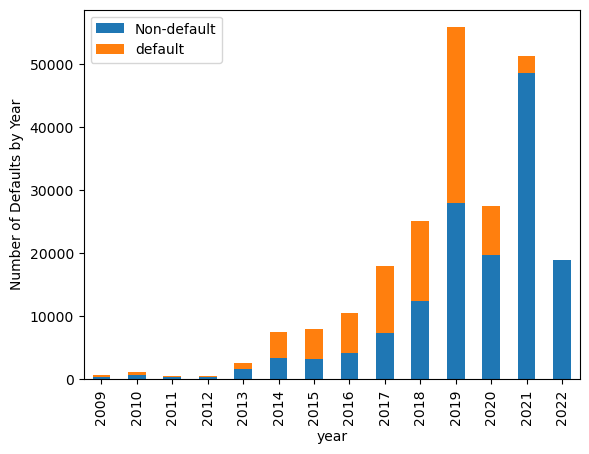

In [15]:
datecolumns.groupby("year")["default"].value_counts().unstack().plot.bar(
    stacked=True, ylabel="Number of Defaults by Year"
)
plt.legend(["Non-default", "default"])
plt.show()

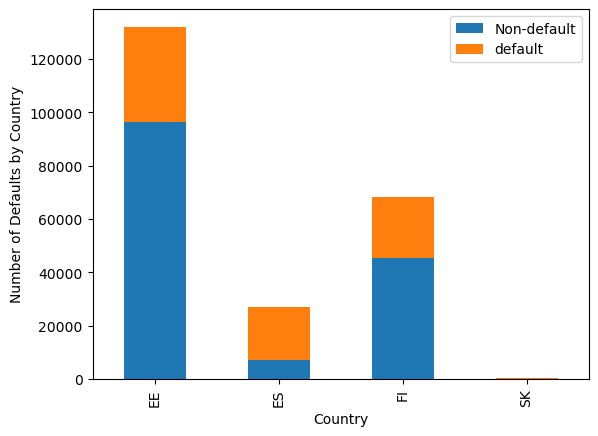

In [16]:
datecolumns.groupby("Country")["default"].value_counts().unstack().plot.bar(
    stacked=True, ylabel="Number of Defaults by Country"
)
plt.legend(["Non-default", "default"])
plt.show()

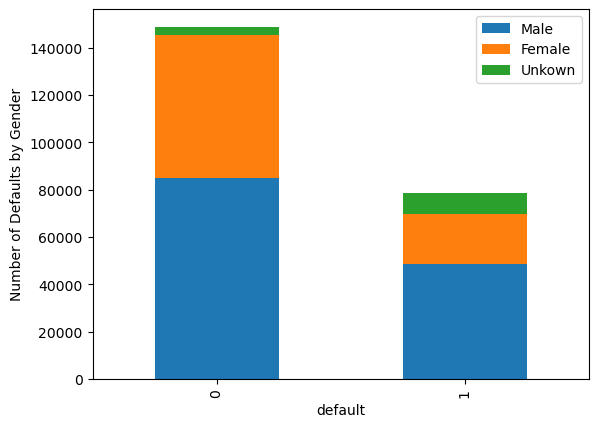

In [17]:
datecolumns.groupby("default")["Gender"].value_counts().unstack().plot.bar(
    stacked=True, ylabel="Number of Defaults by Gender"
)
plt.legend(["Male", "Female", "Unkown"])
plt.show()

## Preprocess dataset

In [18]:
df_target = df_loandata["default"]
df_features = df_loandata.drop(columns=["default"])

In [19]:
df_features.head(2)

,ReportAsOfEOD,LoanId,LoanNumber,ListedOnUTC,BiddingStartedOn,BidsPortfolioManager,BidsApi,BidsManual,PartyId,NewCreditCustomer,...,PreviousEarlyRepaymentsCountBeforeLoan,GracePeriodStart,GracePeriodEnd,NextPaymentDate,NextPaymentNr,NrOfScheduledPayments,ReScheduledOn,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost,ActiveLateLastPaymentCategory
0,2022-04-08,66AE108B-532B-4BB3-BAB7-0019A46412C1,483449,2016-03-23 16:07:19,2016-03-23 16:07:19,970,1150.0,5.0,{EBF05573-554D-4A3B-BC77-A2CF00B7D110},False,...,0.0,2019-10-28,2020-01-27,NaN,NaN,NaN,NaN,0.0,62.31,1-7
1,2022-04-08,D152382E-A50D-46ED-8FF2-0053E0C86A70,378148,2015-06-25 11:02:28,2015-06-25 11:02:28,1295,0.0,1705.0,{46C6CBA4-0FBE-44AD-9304-A3EF0111A5FB},False,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,47.08,180+


In [20]:
 # Calculate threshold for 50% missing values and drop columns with more than 50% missing values
threshold = len(df_features) * 0.5 
df_features.dropna(thresh=threshold, axis=1, inplace=True)

### feature selection 
Using CatBoost for feature selection after trying different feature selection methods

In [21]:
df_features = df_features.select_dtypes(exclude=["object"])

In [22]:
X = df_features
y = df_target

In [23]:
train_pool = Pool(X, y)

In [24]:
catb_model = CatBoostClassifier()
catb_model.fit(train_pool)

Learning rate set to 0.104607
0:	learn: 0.3989529	total: 83ms	remaining: 1m 22s
1:	learn: 0.2379396	total: 104ms	remaining: 52s
2:	learn: 0.1527513	total: 124ms	remaining: 41.2s
3:	learn: 0.1132769	total: 145ms	remaining: 36s
4:	learn: 0.0900137	total: 165ms	remaining: 32.8s
5:	learn: 0.0770669	total: 185ms	remaining: 30.7s
6:	learn: 0.0689234	total: 206ms	remaining: 29.2s
7:	learn: 0.0618961	total: 224ms	remaining: 27.8s
8:	learn: 0.0554704	total: 244ms	remaining: 26.9s
9:	learn: 0.0515532	total: 263ms	remaining: 26.1s
10:	learn: 0.0490875	total: 282ms	remaining: 25.3s
11:	learn: 0.0464718	total: 300ms	remaining: 24.7s
12:	learn: 0.0449266	total: 319ms	remaining: 24.2s
13:	learn: 0.0431910	total: 338ms	remaining: 23.8s
14:	learn: 0.0415116	total: 357ms	remaining: 23.4s
15:	learn: 0.0402158	total: 376ms	remaining: 23.1s
16:	learn: 0.0390198	total: 396ms	remaining: 22.9s
17:	learn: 0.0381574	total: 415ms	remaining: 22.6s
18:	learn: 0.0374285	total: 433ms	remaining: 22.4s
19:	learn: 0.03

In [25]:
catb_feature_importance = pd.Series(catb_model.feature_importances_, index=X.columns)
best_features_catb = catb_feature_importance.nlargest(25)

In [26]:
best_features_catb

RecoveryStage                     32.124507
NextPaymentNr                     23.265205
PrincipalPaymentsMade              6.086864
PrincipalOverdueBySchedule         4.669865
PlannedInterestTillDate            4.478081
InterestAndPenaltyPaymentsMade     4.181604
InterestAndPenaltyBalance          3.461648
PrincipalBalance                   2.958480
Amount                             2.729462
LoanNumber                         2.303462
NrOfScheduledPayments              1.521021
LanguageCode                       1.221656
Restructured                       0.872807
AppliedAmount                      0.775633
ExpectedLoss                       0.745593
LoanDuration                       0.617385
Interest                           0.582260
MonthlyPayment                     0.512752
LiabilitiesTotal                   0.487682
Age                                0.479358
ExpectedReturn                     0.418769
ModelVersion                       0.339980
DebtToIncome                    

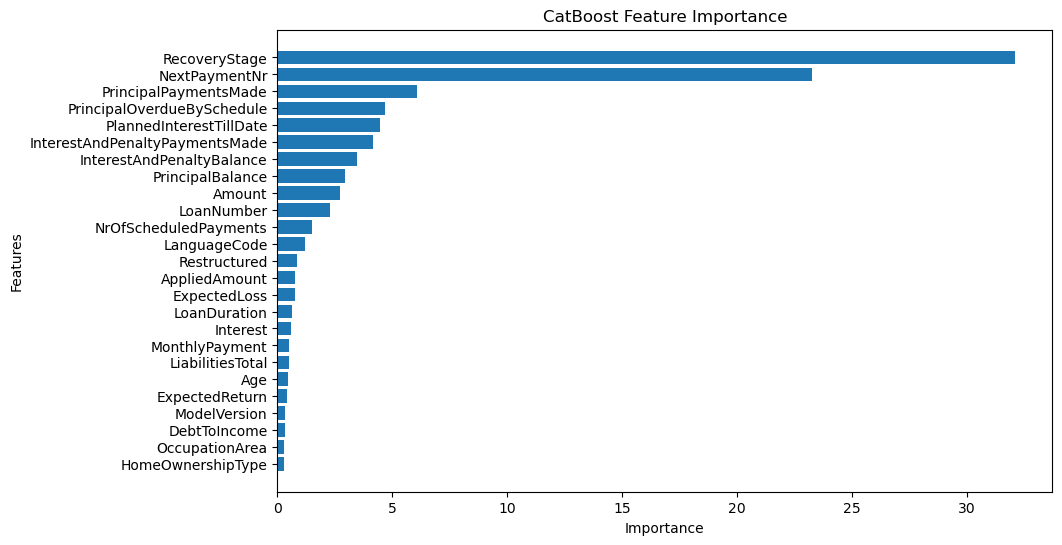

In [27]:
plt.figure(figsize=(10, 6))
plt.barh(best_features_catb.index, best_features_catb.values)
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [28]:
features_list = best_features_catb.index.to_list()
features_list

['RecoveryStage',
 'NextPaymentNr',
 'PrincipalPaymentsMade',
 'PrincipalOverdueBySchedule',
 'PlannedInterestTillDate',
 'InterestAndPenaltyPaymentsMade',
 'InterestAndPenaltyBalance',
 'PrincipalBalance',
 'Amount',
 'LoanNumber',
 'NrOfScheduledPayments',
 'LanguageCode',
 'Restructured',
 'AppliedAmount',
 'ExpectedLoss',
 'LoanDuration',
 'Interest',
 'MonthlyPayment',
 'LiabilitiesTotal',
 'Age',
 'ExpectedReturn',
 'ModelVersion',
 'DebtToIncome',
 'OccupationArea',
 'HomeOwnershipType']

In [29]:
selected_features = df_features.reindex(features_list, axis="columns")

In [30]:
selected_features.head()

,RecoveryStage,NextPaymentNr,PrincipalPaymentsMade,PrincipalOverdueBySchedule,PlannedInterestTillDate,InterestAndPenaltyPaymentsMade,InterestAndPenaltyBalance,PrincipalBalance,Amount,LoanNumber,...,LoanDuration,Interest,MonthlyPayment,LiabilitiesTotal,Age,ExpectedReturn,ModelVersion,DebtToIncome,OccupationArea,HomeOwnershipType
0,2.0,NaN,988.81,1136.19,1251.98,1187.91,507.21,1136.19,2125.0,483449,...,60,20.97,62.05,485.09,53,0.141145,2.0,26.29,1.0,1.0
1,2.0,NaN,563.59,2436.41,3000.00,360.07,2429.70,2436.41,3000.0,378148,...,60,17.12,84.75,736.45,50,0.140436,1.0,30.58,7.0,1.0
2,2.0,NaN,6537.00,0.00,9100.00,1708.47,0.00,0.00,9100.0,451831,...,60,13.67,268.57,905.00,44,0.113484,2.0,26.71,8.0,8.0
3,1.0,NaN,464.73,1035.27,1500.00,355.92,2972.09,1035.27,1500.0,349381,...,60,40.40,63.53,350.00,42,0.183229,1.0,7.36,1.0,2.0
4,1.0,NaN,0.01,1089.99,1090.00,0.00,4461.78,1089.99,1090.0,443082,...,48,68.39,101.19,940.00,34,0.115240,2.0,36.04,1.0,3.0


In [31]:
# Checking the correlation between variables to avoid multicollinearity in the logistic regression 
correlation = selected_features.corr()
correlation

,RecoveryStage,NextPaymentNr,PrincipalPaymentsMade,PrincipalOverdueBySchedule,PlannedInterestTillDate,InterestAndPenaltyPaymentsMade,InterestAndPenaltyBalance,PrincipalBalance,Amount,LoanNumber,...,LoanDuration,Interest,MonthlyPayment,LiabilitiesTotal,Age,ExpectedReturn,ModelVersion,DebtToIncome,OccupationArea,HomeOwnershipType
RecoveryStage,1.000000,-0.525569,-0.105813,0.405680,0.212598,-0.124256,0.272424,0.084446,0.038813,-0.428994,...,-0.016125,0.206058,0.128058,0.004138,0.009758,0.151198,-0.102796,0.194191,0.184151,0.018073
NextPaymentNr,-0.525569,1.000000,0.271524,-0.247383,0.084053,0.199066,-0.290244,-0.147807,-0.039734,-0.010756,...,-0.027986,-0.155514,-0.086073,-0.006160,0.067304,-0.141898,0.001029,-0.024295,-0.023416,-0.013868
PrincipalPaymentsMade,-0.105813,0.271524,1.000000,-0.066694,0.674120,0.415227,-0.097124,-0.228116,0.507199,-0.255015,...,-0.015774,-0.052366,0.400955,0.000887,0.029917,0.007227,-0.077284,0.199842,0.161810,0.028808
PrincipalOverdueBySchedule,0.405680,-0.247383,-0.066694,1.000000,0.493899,0.039459,0.666387,0.369160,0.298234,-0.353158,...,-0.041367,0.155587,0.355987,0.001897,0.043388,0.103817,-0.081237,0.306628,0.265712,0.016981
PlannedInterestTillDate,0.212598,0.084053,0.674120,0.493899,1.000000,0.252464,0.316255,0.014213,0.516799,-0.270121,...,0.016244,0.042593,0.453121,0.001410,0.052731,0.047197,-0.074782,0.200334,0.142306,0.027584
InterestAndPenaltyPaymentsMade,-0.124256,0.199066,0.415227,0.039459,0.252464,1.000000,-0.003843,0.217228,0.486170,-0.254862,...,0.108878,0.099091,0.400691,-0.000061,0.068636,0.127476,-0.075888,0.160707,0.120861,0.032757
InterestAndPenaltyBalance,0.272424,-0.290244,-0.097124,0.666387,0.316255,-0.003843,1.000000,0.350443,0.233690,-0.250467,...,0.039108,0.250967,0.274211,0.001200,0.000845,0.036935,-0.103575,0.226039,0.185288,0.000974
PrincipalBalance,0.084446,-0.147807,-0.228116,0.369160,0.014213,0.217228,0.350443,1.000000,0.713755,0.269475,...,0.310445,-0.029067,0.472333,-0.002772,0.081271,-0.052713,-0.001762,-0.112772,-0.146948,-0.004285
Amount,0.038813,-0.039734,0.507199,0.298234,0.516799,0.486170,0.233690,0.713755,1.000000,0.046811,...,0.265501,-0.059732,0.707582,-0.001608,0.093203,-0.043147,-0.059402,0.053983,-0.006991,0.016408
LoanNumber,-0.428994,-0.010756,-0.255015,-0.353158,-0.270121,-0.254862,-0.250467,0.269475,0.046811,1.000000,...,0.236396,-0.228597,-0.135338,-0.004239,-0.005123,-0.252672,0.227779,-0.486060,-0.524073,-0.031718


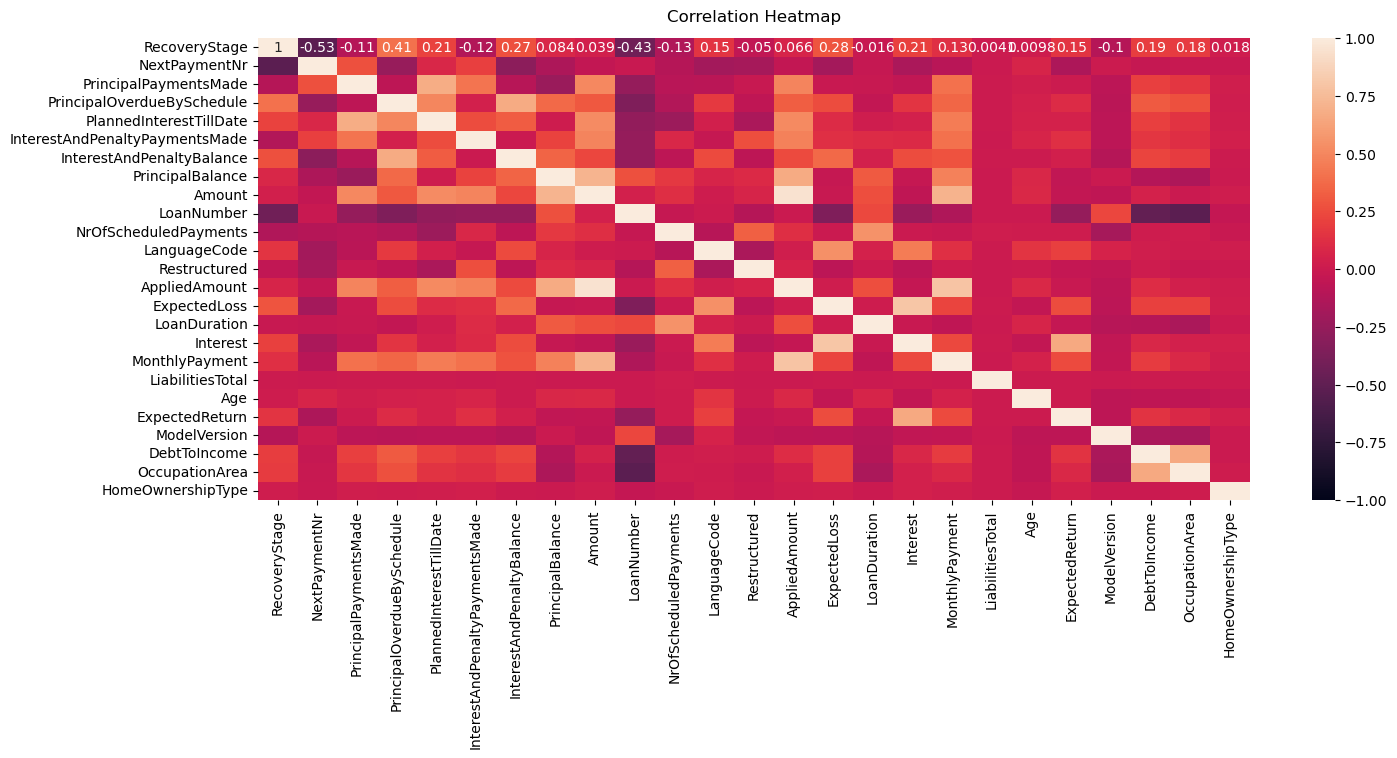

In [32]:
plt.figure(figsize=(16, 6))
correlation_matrix = sns.heatmap(selected_features.corr(), vmin=-1, vmax=1, annot=True)
correlation_matrix.set_title("Correlation Heatmap", fontdict={"fontsize": 12}, pad=12);

In [33]:
def find_high_correlation_pairs(df, threshold=0.70):
    # Calculate correlation matrix
    corr_matrix = selected_features.corr()

    # Get pairs of columns with correlation greater than the threshold
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append(
                    (
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_matrix.iloc[i, j],
                    )
                )

    return high_corr_pairs


high_corr_pairs = find_high_correlation_pairs(selected_features)

# Print pairs with correlation coefficient greater than 0.70
for pair in high_corr_pairs:
    print(
        "High correlation between:",
        pair[0],
        "and",
        pair[1],
        "- Correlation coefficient:",
        pair[2],
    )

High correlation between: PrincipalBalance and Amount - Correlation coefficient: 0.7137549387517578
High correlation between: Amount and AppliedAmount - Correlation coefficient: 0.9457222496842939
High correlation between: Amount and MonthlyPayment - Correlation coefficient: 0.7075819099260459
High correlation between: AppliedAmount and MonthlyPayment - Correlation coefficient: 0.7925117421819856
High correlation between: ExpectedLoss and Interest - Correlation coefficient: 0.7973001428243


In [34]:
# removing Amount because it is highly correlated with 3 other variables
# Removing Interest and MonthlyPayment because they have a lower feature importance
# removing RecoveryStage and NextPaymentNr as they lead to near perfect predictions

selected_features = selected_features.drop(
    ["Amount", "Interest", "MonthlyPayment", "RecoveryStage", "NextPaymentNr"], axis=1
)

In [35]:
selected_features.head()

,PrincipalPaymentsMade,PrincipalOverdueBySchedule,PlannedInterestTillDate,InterestAndPenaltyPaymentsMade,InterestAndPenaltyBalance,PrincipalBalance,LoanNumber,NrOfScheduledPayments,LanguageCode,Restructured,AppliedAmount,ExpectedLoss,LoanDuration,LiabilitiesTotal,Age,ExpectedReturn,ModelVersion,DebtToIncome,OccupationArea,HomeOwnershipType
0,988.81,1136.19,1251.98,1187.91,507.21,1136.19,483449,NaN,1,False,2125.0,0.068512,60,485.09,53,0.141145,2.0,26.29,1.0,1.0
1,563.59,2436.41,3000.00,360.07,2429.70,2436.41,378148,NaN,1,False,3000.0,0.030799,60,736.45,50,0.140436,1.0,30.58,7.0,1.0
2,6537.00,0.00,9100.00,1708.47,0.00,0.00,451831,NaN,1,False,10630.0,0.023177,60,905.00,44,0.113484,2.0,26.71,8.0,8.0
3,464.73,1035.27,1500.00,355.92,2972.09,1035.27,349381,NaN,6,False,1500.0,0.220810,60,350.00,42,0.183229,1.0,7.36,1.0,2.0
4,0.01,1089.99,1090.00,0.00,4461.78,1089.99,443082,NaN,6,False,1595.0,0.568678,48,940.00,34,0.115240,2.0,36.04,1.0,3.0


#### More data cleaning 

In [36]:
combined_data = pd.concat([selected_features, df_target], axis=1)
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227741 entries, 0 to 227740
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PrincipalPaymentsMade           227741 non-null  float64
 1   PrincipalOverdueBySchedule      212895 non-null  float64
 2   PlannedInterestTillDate         223356 non-null  float64
 3   InterestAndPenaltyPaymentsMade  227741 non-null  float64
 4   InterestAndPenaltyBalance       174005 non-null  float64
 5   PrincipalBalance                227741 non-null  float64
 6   LoanNumber                      227741 non-null  int64  
 7   NrOfScheduledPayments           138005 non-null  float64
 8   LanguageCode                    227741 non-null  int64  
 9   Restructured                    227741 non-null  bool   
 10  AppliedAmount                   227741 non-null  float64
 11  ExpectedLoss                    225102 non-null  float64
 12  LoanDuration    

In [37]:
combined_data.LanguageCode.unique()

array([ 1,  6,  4,  3,  2,  5,  9, 10, 13, 22,  7, 21, 15])

In [38]:
# encoded languages: 1 Estonian 2 English 3 Russian 4 Finnish 5 German 6 Spanish 9 Slovakian. Dropping values that do not encode anything
values = [10, 13, 22, 7, 21, 15]
combined_data = combined_data[combined_data.LanguageCode.isin(values) == False]
combined_data.LanguageCode.unique()

array([1, 6, 4, 3, 2, 5, 9])

In [39]:
combined_data.OccupationArea.unique()

array([ 1.,  7.,  8.,  9., 11., 13., 19., 17.,  3.,  6., 14., 12.,  4.,
       16., 10., -1., 15.,  5., 18.,  2., nan,  0.])

In [40]:
# remove OccupationArea variables that do not encode anything
non_occupation_values = [0, -1]
combined_data = combined_data[
    combined_data.OccupationArea.isin(non_occupation_values) == False
]
combined_data.OccupationArea.unique()

array([ 1.,  7.,  8.,  9., 11., 13., 19., 17.,  3.,  6., 14., 12.,  4.,
       16., 10., 15.,  5., 18.,  2., nan])

#### Missing Value Imputation

In [41]:
target_column = combined_data["default"].copy()
numerical_columns = combined_data.drop(
    columns=["default", "LanguageCode", "OccupationArea", "HomeOwnershipType"]
)
categorical_columns = combined_data[
    ["LanguageCode", "OccupationArea", "HomeOwnershipType"]
].copy()

In [42]:
#imput numerical values by the mean of the column and input categorical values by the mode of the column
numerical_columns = numerical_columns.fillna(numerical_columns.mean())
categorical_columns = categorical_columns.fillna(
    categorical_columns.mode(dropna=True).iloc[0]
)

One hot encode categorical values

In [43]:
categorical_columns = categorical_columns.astype(int)

In [44]:
#replace OccupationArea with the corresponding occupation
categorical_columns["OccupationArea"] = categorical_columns["OccupationArea"].replace(
    {
        1: "Other",
        2: "Mining",
        3: "Processing",
        4: "Energy",
        5: "Utilities",
        6: "Construction",
        7: "Retail and wholesale",
        8: "Transport and warehousing",
        9: "Hospitality and catering",
        10: "Info and telecom",
        11: "Finance and insurance",
        12: "Real-estate",
        13: "Research",
        14: "Administrative",
        15: "Civil service & military",
        16: "Education",
        17: "Healthcare and social help",
        18: "Art and entertainment",
        19: "Agriculture, forestry and fishing",
    }
)

In [45]:
#replace LanguageCode with the corresponding language code
categorical_columns["LanguageCode"] = categorical_columns["LanguageCode"].replace(
    {
        1: "Estonian",
        2: "English",
        3: "Russian",
        4: "Finnish",
        5: "German",
        6: "Spanish",
        9: "Slovakian",
    }
)

In [46]:
#replace HomeOwnershipType with the corresponding home ownership Type
categorical_columns["HomeOwnershipType"] = categorical_columns[
    "HomeOwnershipType"
].replace(
    {
        0: "Homeless",
        1: "Owner",
        2: "Living with parents",
        3: "Tenant, pre-furnished property",
        4: "Tenant, unfurnished property",
        5: "Council house",
        6: "Joint tenant",
        7: "Joint ownership",
        8: "Mortgage",
        9: "Owner with encumbrance",
        10: "Other",
    }
)

In [47]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(categorical_columns)
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())

In [48]:
# drop of of each of the encoded columns to avoid multi-collinearity between variables
one_hot_df = one_hot_df.drop(
    columns=[
        "LanguageCode_English",
        "OccupationArea_Administrative",
        "HomeOwnershipType_Homeless",
    ]
)

In [49]:
one_hot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36517 entries, 0 to 36516
Data columns (total 33 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   LanguageCode_Estonian                             36517 non-null  float64
 1   LanguageCode_Finnish                              36517 non-null  float64
 2   LanguageCode_German                               36517 non-null  float64
 3   LanguageCode_Russian                              36517 non-null  float64
 4   LanguageCode_Slovakian                            36517 non-null  float64
 5   LanguageCode_Spanish                              36517 non-null  float64
 6   OccupationArea_Agriculture, forestry and fishing  36517 non-null  float64
 7   OccupationArea_Art and entertainment              36517 non-null  float64
 8   OccupationArea_Civil service & military           36517 non-null  float64
 9   OccupationArea_Co

Winsorize and standardize mumerical variables

In [50]:
# winsorize numerical values by 1% in each tail because of the outliers
for col in numerical_columns.columns:
    numerical_columns[col] = list(
        winsorize(numerical_columns[col], limits=[0.01, 0.01])
    )

In [51]:
# standardize the numerical columns due to best practice. ML models used are not senstive to variables of different maginitudes
scaler = StandardScaler()
standardized_num_cols = scaler.fit_transform(numerical_columns)
standardized_num_cols = pd.DataFrame(
    data=standardized_num_cols, columns=numerical_columns.columns
)

combine all data frames into one 

In [52]:
proccessed_df = pd.concat([standardized_num_cols, one_hot_df, target_column], axis=1)

In [53]:
proccessed_df = proccessed_df.dropna()

### Logistic Regression
The traditional statistical model


In [54]:
Y = proccessed_df["default"].copy()
X = proccessed_df.drop(["default"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42
)

In [55]:
LogisticRegression(max_iter=1e6, penalty="l1", solver="saga", random_state=1)
model = LogisticRegression().fit(X_train, y_train)

In [56]:
y_pred = model.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("f1 score:", metrics.f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC Score:", metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.5932721712538226
Precision: 0.5948945615982242
Recall: 0.8137651821862348
f1 score: 0.6873263517845694
              precision    recall  f1-score   support

         0.0       0.59      0.32      0.42      3242
         1.0       0.59      0.81      0.69      3952

    accuracy                           0.59      7194
   macro avg       0.59      0.57      0.55      7194
weighted avg       0.59      0.59      0.57      7194

AUC Score: 0.5691281185453074


### Random Forest

In [57]:
model_rf = RandomForestClassifier(
    max_depth=10, random_state=1, min_samples_leaf=10
).fit(X_train, y_train)

In [58]:
y_train_pred = model_rf.predict(X_train)
print("Accuracy:", metrics.accuracy_score(y_train, y_train_pred))
print("Precision:", metrics.precision_score(y_train, y_train_pred))
print("Recall:", metrics.recall_score(y_train, y_train_pred))
print("f1 score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.6086049906165288
Precision: 0.5944821731748726
Recall: 0.8913071146748123
f1 score: 0.6873263517845694


In [59]:
y_test_pred = model_rf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:", metrics.precision_score(y_test, y_test_pred))
print("Recall:", metrics.recall_score(y_test, y_test_pred))
print("f1 score:", metrics.f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("AUC Score:", metrics.roc_auc_score(y_test, y_test_pred))

Accuracy: 0.6057825966082847
Precision: 0.5954825462012321
Recall: 0.8805668016194332
f1 score: 0.7104940792160066
              precision    recall  f1-score   support

         0.0       0.65      0.27      0.38      3242
         1.0       0.60      0.88      0.71      3952

    accuracy                           0.61      7194
   macro avg       0.62      0.58      0.55      7194
weighted avg       0.62      0.61      0.56      7194

AUC Score: 0.5756936414019436


### Decision Tree

In [60]:
dt = DecisionTreeClassifier().fit(X_train, y_train)

In [61]:
y_train_dt = dt.predict(X_train)
print("Accuracy:", metrics.accuracy_score(y_train, y_train_dt))
print("Precision:", metrics.precision_score(y_train, y_train_dt))
print("Recall:", metrics.recall_score(y_train, y_train_dt))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


In [62]:
y_test_dt = dt.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_test_dt))
print("Precision:", metrics.precision_score(y_test, y_test_dt))
print("Recall:", metrics.recall_score(y_test, y_test_dt))
print("f1 score:", metrics.f1_score(y_test, y_test_dt))
print(classification_report(y_test, y_test_dt))
print("AUC Score:", metrics.roc_auc_score(y_test, y_test_dt))

Accuracy: 0.512510425354462
Precision: 0.5578673602080624
Recall: 0.5427631578947368
f1 score: 0.55021161985379
              precision    recall  f1-score   support

         0.0       0.46      0.48      0.47      3242
         1.0       0.56      0.54      0.55      3952

    accuracy                           0.51      7194
   macro avg       0.51      0.51      0.51      7194
weighted avg       0.51      0.51      0.51      7194

AUC Score: 0.509197741809799


### Decision Tree with Grid search paramters

In [63]:
tree = DecisionTreeClassifier(
    criterion="entropy", max_depth=6, max_features=8, min_samples_leaf=4
).fit(X_train, y_train)

In [64]:
y_train_tree = tree.predict(X_train)
print("Accuracy:", metrics.accuracy_score(y_train, y_train_tree))
print("Precision:", metrics.precision_score(y_train, y_train_tree))
print("Recall:", metrics.recall_score(y_train, y_train_tree))
print("f1 score:", metrics.f1_score(y_train, y_train_tree))
print(classification_report(y_train, y_train_tree))

Accuracy: 0.594321262250643
Precision: 0.5849842271293375
Recall: 0.8850706376479572
f1 score: 0.7043986933069969
              precision    recall  f1-score   support

         0.0       0.64      0.24      0.35     13060
         1.0       0.58      0.89      0.70     15714

    accuracy                           0.59     28774
   macro avg       0.61      0.56      0.53     28774
weighted avg       0.61      0.59      0.55     28774



In [65]:
y_test_tree = tree.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_test_tree))
print("Precision:", metrics.precision_score(y_test, y_test_tree))
print("Recall:", metrics.recall_score(y_test, y_test_tree))
print("f1 score:", metrics.f1_score(y_test, y_test_tree))
print(classification_report(y_test, y_test_tree))

Accuracy: 0.5960522657770364
Precision: 0.5893711551606289
Recall: 0.8727226720647774
f1 score: 0.7035903712770298
              precision    recall  f1-score   support

         0.0       0.63      0.26      0.37      3242
         1.0       0.59      0.87      0.70      3952

    accuracy                           0.60      7194
   macro avg       0.61      0.57      0.53      7194
weighted avg       0.61      0.60      0.55      7194



### Gradient Boosting Decision Tree

In [66]:
train_pool = Pool(X_train, y_train)

In [67]:
model_catb = CatBoostClassifier(
    iterations=20, depth=10, learning_rate=1, loss_function="Logloss", verbose=True
)
# train the model
model_catb.fit(train_pool)

0:	learn: 0.6708253	total: 33.3ms	remaining: 633ms
1:	learn: 0.6631042	total: 64.5ms	remaining: 581ms
2:	learn: 0.6561040	total: 84.1ms	remaining: 477ms
3:	learn: 0.6490350	total: 105ms	remaining: 419ms
4:	learn: 0.6436991	total: 122ms	remaining: 365ms
5:	learn: 0.6389662	total: 138ms	remaining: 322ms
6:	learn: 0.6318599	total: 152ms	remaining: 282ms
7:	learn: 0.6220225	total: 165ms	remaining: 247ms
8:	learn: 0.6102458	total: 178ms	remaining: 218ms
9:	learn: 0.6040347	total: 190ms	remaining: 190ms
10:	learn: 0.5934852	total: 203ms	remaining: 166ms
11:	learn: 0.5825371	total: 216ms	remaining: 144ms
12:	learn: 0.5737037	total: 229ms	remaining: 123ms
13:	learn: 0.5645653	total: 242ms	remaining: 104ms
14:	learn: 0.5575850	total: 254ms	remaining: 84.8ms
15:	learn: 0.5485492	total: 267ms	remaining: 66.8ms
16:	learn: 0.5401749	total: 281ms	remaining: 49.6ms
17:	learn: 0.5341126	total: 293ms	remaining: 32.5ms
18:	learn: 0.5256793	total: 305ms	remaining: 16.1ms
19:	learn: 0.5190605	total: 317ms

In [68]:
y_train_catb = model_catb.predict(X_train)
print("Accuracy:", metrics.accuracy_score(y_train, y_train_catb))
print("Precision:", metrics.precision_score(y_train, y_train_catb))
print("Recall:", metrics.recall_score(y_train, y_train_catb))
print("f1 score:", metrics.f1_score(y_train, y_train_catb))

Accuracy: 0.7376103426704664


Precision: 0.7404004711425206
Recall: 0.8000509100165457
f1 score: 0.7690707775126935


In [69]:
y_test_catb = model_catb.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_test_catb))
print("Precision:", metrics.precision_score(y_test, y_test_catb))
print("Recall:", metrics.recall_score(y_test, y_test_catb))
print("f1 score:", metrics.f1_score(y_test, y_test_catb))
print(classification_report(y_test, y_test_catb))

Accuracy: 0.550597720322491
Precision: 0.5846081430924923
Recall: 0.6285425101214575
f1 score: 0.6057797829532984
              precision    recall  f1-score   support

         0.0       0.50      0.46      0.48      3242
         1.0       0.58      0.63      0.61      3952

    accuracy                           0.55      7194
   macro avg       0.54      0.54      0.54      7194
weighted avg       0.55      0.55      0.55      7194



### CatBoost with default parameters

In [70]:
train_pool = Pool(X_train, y_train)

In [71]:
model_catb = CatBoostClassifier(
    iterations=20, depth=10, learning_rate=1, loss_function="Logloss", verbose=True
)

In [72]:
# train the model
model_catb.fit(train_pool)

0:	learn: 0.6708253	total: 15.9ms	remaining: 301ms


1:	learn: 0.6631042	total: 32ms	remaining: 288ms
2:	learn: 0.6561040	total: 45.7ms	remaining: 259ms
3:	learn: 0.6490350	total: 58.4ms	remaining: 234ms
4:	learn: 0.6436991	total: 71ms	remaining: 213ms
5:	learn: 0.6389662	total: 82.9ms	remaining: 193ms
6:	learn: 0.6318599	total: 94.7ms	remaining: 176ms
7:	learn: 0.6220225	total: 108ms	remaining: 162ms
8:	learn: 0.6102458	total: 122ms	remaining: 149ms
9:	learn: 0.6040347	total: 136ms	remaining: 136ms
10:	learn: 0.5934852	total: 150ms	remaining: 123ms
11:	learn: 0.5825371	total: 165ms	remaining: 110ms
12:	learn: 0.5737037	total: 179ms	remaining: 96.3ms
13:	learn: 0.5645653	total: 193ms	remaining: 82.8ms
14:	learn: 0.5575850	total: 207ms	remaining: 69.1ms
15:	learn: 0.5485492	total: 221ms	remaining: 55.4ms
16:	learn: 0.5401749	total: 271ms	remaining: 47.9ms
17:	learn: 0.5341126	total: 308ms	remaining: 34.3ms
18:	learn: 0.5256793	total: 339ms	remaining: 17.8ms
19:	learn: 0.5190605	total: 360ms	remaining: 0us


In [73]:
y_train_catb = model_catb.predict(X_train)
print("Accuracy:", metrics.accuracy_score(y_train, y_train_catb))
print("Precision:", metrics.precision_score(y_train, y_train_catb))
print("Recall:", metrics.recall_score(y_train, y_train_catb))
print("f1 score:", metrics.f1_score(y_train, y_train_catb))

Accuracy: 0.7376103426704664
Precision: 0.7404004711425206
Recall: 0.8000509100165457
f1 score: 0.7690707775126935


In [74]:
y_test_catp = model_catb.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_test_catp))
print("Precision:", metrics.precision_score(y_test, y_test_catp))
print("Recall:", metrics.recall_score(y_test, y_test_catp))
print("f1 score:", metrics.f1_score(y_test, y_test_catp))
print(classification_report(y_test, y_test_catp))
print("AUC Score:", metrics.roc_auc_score(y_test, y_test_catp))

Accuracy: 0.550597720322491
Precision: 0.5846081430924923
Recall: 0.6285425101214575
f1 score: 0.6057797829532984
              precision    recall  f1-score   support

         0.0       0.50      0.46      0.48      3242
         1.0       0.58      0.63      0.61      3952

    accuracy                           0.55      7194
   macro avg       0.54      0.54      0.54      7194
weighted avg       0.55      0.55      0.55      7194

AUC Score: 0.5420627417973111


### Naive Bayes

In [75]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [76]:
y_train_gnb = gnb.predict(X_train)
print("Accuracy:", metrics.accuracy_score(y_train, y_train_gnb))
print("Precision:", metrics.precision_score(y_train, y_train_gnb))
print("Recall:", metrics.recall_score(y_train, y_train_gnb))
print("f1 score:", metrics.f1_score(y_train, y_train_gnb))

Accuracy: 0.4567665253353722
Precision: 0.6343042071197411
Recall: 0.012472954053710067
f1 score: 0.024464831804281346


In [77]:
y_test_gnb = gnb.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_test_gnb))
print("Precision:", metrics.precision_score(y_test, y_test_gnb))
print("Recall:", metrics.recall_score(y_test, y_test_gnb))
print("f1 score:", metrics.f1_score(y_test, y_test_gnb))
print(classification_report(y_test, y_test_gnb))
print("AUC Score:", metrics.roc_auc_score(y_test, y_test_gnb))

Accuracy: 0.4510703363914373
Precision: 0.5223880597014925
Recall: 0.008856275303643725
f1 score: 0.017417267977108734
              precision    recall  f1-score   support

         0.0       0.45      0.99      0.62      3242
         1.0       0.52      0.01      0.02      3952

    accuracy                           0.45      7194
   macro avg       0.49      0.50      0.32      7194
weighted avg       0.49      0.45      0.29      7194

AUC Score: 0.4994929124821735
